# Shallow Water Finite Volume Models

It is recommended to run all these notebooks at least once, in order to generate all modules.


## Schemes considering horizontal bottom

### Dambreak analytical solution

[dambreak.ipynb](dambreak.ipynb)

The first analytical solution we tried for validating our schemes.

It generates the module **dambreak.py**, which contains routines to obtain this solution given some parameters.

### First order scheme

[nswe_order1.ipynb](nswe_order1.ipynb)

An implementation of a shock capturing first order scheme. It also contains a discussion of instabilities observed in numerical experiments for the dambreak solution with dry bottom and open or closed boundary conditions.

It requires the module **dambreak.py**.

It generates the module **nswe1.py**, which contains the implementation of this solver.

### Second order scheme

[nswe_muscl_2order.ipynb](nswe_muscl_2order.ipynb)

It uses the same FV formulation but with second order MUSCL reconstruction of variables. Here is also a discussion about the MUSCL slope limiters, and some quick numerical tests.

It requieres the module **nswe1.py** (for comparison).

It generates the module **muscl2.py**.

## Fourth order scheme

[nswe_muscl_4order.ipynb (**deprecated**)](swe_muscl_4order.ipynb)

Same FV formulation but with a fourth o




This notebook is deprecated. Its bugs were solved when using $h$ and $u$ as input/output instead of $h$ and $hu$. This is because less divisions by $h\approx 0$ are done.
See [nswe_muscl_4order_reconstruct_u.ipynb](nswe_muscl_4order_reconstruct_u.ipynb) instead.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Fourth order MUSCL reconstruction

The first step consists in aproximating the solution by a linear function choosing an appropriate slope.


Setting $h$ as the variable to reconstruct (it can be the actual $h$ but the same procedure has to be done on $u$). Notice that to account for all the interfaces we need to calculate $\delta h_{i,r}$ for $i$ from $-1$ to $n_x-1$ and $\delta h_{i,l}$ for $i$ from $0$ to $n_x$ 

First we calculate $ \delta h_{i,l}$ for $i=0...n_x$ to obtain values at the left interface of each cell

\begin{equation}
\begin{split}
    \delta h_{i,l} &= 
    (1-\nu)(h_i^n-h_{i-1}^n) + 
    \nu(h_{i+1}^n-h_{i}) +
    \xi^c(-h_{i-2}+3h_{i-1}^n-3h_i^n+h_{i+1}^n) +
    \xi^d(-h_{i-1}^n +3h_i^n - 3h_{i+1}^n+h_{i+2}^n ) \\
    &= h_{i-2}^n ( -\xi^c)+
       h_{i-1}^n (-(1-\nu) +3\xi^c-\xi^d) +
       h_i^n ((1-2\nu) - 3\xi^c + 3 \xi^d) +
       h_{i+1}^n( \nu + \xi^c - 3\xi^d) +
       h_{i+2}^n(\xi^d)
\end{split}
\end{equation}

and at the right interface $ \delta h_{i,r}$ for $i=-1...n_x-1$

\begin{equation}
    \begin{split}
        \delta h_{i,r} &= 
        (1-\nu)(h_{i+1}^n-h_i^n) + 
        \nu( h_i^n - h_{i-1}) + 
        \xi^c( -h_{i-1}^n + 3h_i^n - 3h_{i+1}^n + h_{i+2}^n) +
        \xi^d(-h_{i-2}^n + 3h_{i-1} -3 h_i^n + h_{i+1}^n) \\
        &= h_{i-2}^n (-\xi^d) +
        h_{i-1}^n(-\nu - \xi^c + 3\xi^d ) + 
        h_i^n ( -(1-2\nu) + 3\xi^c-3\xi^d ) +
        h_{i+1}^n( (1-\nu) - 3\xi^c +\xi^d) +
        h_{i+2}^n (\xi^c)
    \end{split}
\end{equation}

these values will be compared later with the forward and backward differences
$ \delta h_i^{n,+} = h_{i+1}^n-h_i^n$
and $ \delta h_i^{n,-} = h_i^n - h_{i-1}^n$.

We can also see that we require $h$ to be defined for $i$ from $-3$ to $n_x+2$, which shows that three additional ghost cells are required at each side.

In [2]:
a = np.linspace(-3,12,10+6)
j0 = 2
jf = 10+3+1
print a
print a[j0-2:jf-2]
print a[j0:jf]

[ -3.  -2.  -1.   0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.
  12.]
[-3. -2. -1.  0.  1.  2.  3.  4.  5.  6.  7.  8.]
[ -1.   0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.]


In [3]:
def getSlopesReconstruction(h,nu,xic,xid):
    """
        Receives a 1D array h of size nx+6 and
        returns reconstructed values dhil,dhir,dhi+,dhi-,
        for indices i=-1...nx, given scalars nu, xic and xid.       
        The array has the following indexing
        
        ---3---  --------nx-------   ------3--------        
        0, 1, 2, (3, 4, ..., nx+2), nx+3, nx+4, nx+5
        
        
        Notice that hil,hir are unnecessary for i=-1
        and i=nx respectively, but stilled are returned 
        as output to make the code easier.
    """
    nx = h.shape[0] -6
    j0 = 2 #i=-1
    jf = nx+3 +1 #i=nx (first ghost cell=(nx-1)+1), 
                   #+1 for python weird indexing on array operations
                   #doing h[j0:jf] gives "h_i" for i=-1...nx
    

    
    dhil = np.zeros((nx+2,))
    dhir = np.zeros((nx+2,))
    dhplus = np.zeros((nx+2,))
    dhminus = np.zeros((nx+2,))
    for i in range(2,nx+3+1):
        dhir[i-2] = (1.-nu)*(h[i+1]-h[i])+\
                    nu*(h[i]-h[i-1]) + \
                    xic*(-h[i-1] + 3.*h[i] -  3.*h[i+1] + h[i+2]) +\
                    xid*(-h[i-2] + 3.*h[i-1] -3.*h[i] +h[i+1])
        dhil[i-2] = (1.-nu)*(h[i] - h[i-1]) +\
                    nu*(h[i+1] - h[i]) + \
                    xic*(-h[i-2] +3.*h[i-1] -3.*h[i] +h[i+1]) + \
                    xid*(-h[i-1] + 3.*h[i] - 3.*h[i+1] + h[i+2])
        
        dhplus[i-2] = h[i+1] - h[i]
        
        dhminus[i-2] = h[i] - h[i-1]
        
    return dhil, dhir, dhplus, dhminus

In [4]:
def getSlopesReconstruction_2(h,nu,xic,xid):
    """
        Receives a 1D array h of size nx+6 and
        returns reconstructed values dhil,dhir,dhi+,dhi-,
        for indices i=-1...nx, given scalars nu, xic and xid.       
        The array has the following indexing
        
        0, 1, 2, (3, 4, ..., nx-1), nx, nx+1, nx+2
        
        
        Notice that hil,hir are unnecessary for i=-1
        and i=nx respectively, but stilled are returned 
        as output to make the code easier.
    """
    nx = h.shape[0] -6
    j0 = 2 #i=-1
    jf = nx+3 +1 #i=nx (first ghost cell=(nx-1)+1), 
                   #+1 for python weird indexing on array operations
                   #doing h[j0:jf] gives "h_i" for i=-1...nx
    

    dhil = (1.-nu)*(h[j0:jf]-h[j0-1:jf-1]) +\
        nu*(h[j0+1:jf+1]-h[j0:jf]) + \
        xic*(-h[j0-2:jf-2] +3.*h[j0-1:jf-1] -3.*h[j0:jf] + h[j0+1:jf+1])+\
        xid*(-h[j0-1:jf-1] +3.*h[j0:jf] - 3.*h[j0+1:jf+1] + h[j0+2:jf+2])
        
    dhir = (1.-nu)*(h[j0+1:jf+1])-h[j0:jf] +\
            nu*(h[j0:jf]-h[j0-1:jf-1]) +\
            xic*(-h[j0-1:jf-1] + 3.*h[j0:jf] - 3.*h[j0+1:jf+1] + h[j0+2:jf+2]) +\
            xid*(-h[j0-2:jf-2] + 3.*h[j0-1:jf-1] - 3.*h[j0:jf] + h[j0+1:jf+1])
        
    
    
    dhplus = h[j0+1:jf+1]-h[j0:jf]
    
    dhminus = h[j0:jf] - h[j0-1:jf-1]
    
    return dhil, dhir, dhplus, dhminus

In [5]:
def getSlopesReconstruction_3(h,nu,xic,xid):
    """
        Receives a 1D array h of size nx+6 and
        returns reconstructed values dhil,dhir,dhi+,dhi-,
        for indices i=-1...nx, given scalars nu, xic and xid.        
        
        Notice that hil,hir are unnecessary for i=-1
        and i=nx respectively, but stilled are returned 
        as output to make the code easier.
    """
    nx = h.shape[0] -6
    j0 = 2 #i=-1
    jf = nx+3 +1 #i=nx (first ghost cell=(nx-1)+1), 
                   #+1 for python weird indexing on array operations
                   #doing h[j0:jf] gives "h_i" for i=-1...nx
    
    dhil = h[j0-2:jf-2]*(-xic) + \
        h[j0-1:jf-1]*(-1.0*(1.0-nu) + 3.0*xic - xid)+ \
        h[j0:jf]*(1.0-2.*nu - 3.*xic + 3.*xid) + \
        h[j0+1:jf+1]*(nu + xic -3.*xid) + \
        h[j0+2:jf+2]*(xid)
        
    dhir = h[j0-2:jf-2]*(-xid) + \
        h[j0-1:jf-1]*(-nu-xic+3*xid) +\
        h[j0:jf]*(-(1.-2.*nu) + 3.*xic - 3.*xid) + \
        h[j0+1:jf+1]*(1.-nu -3.*xic + xid) + \
        h[j0+2:jf+2]*(xic)   
    
    dhplus = h[j0+1:jf+1]-h[j0:jf]
    
    dhminus = h[j0:jf] - h[j0-1:jf-1]
    
    return dhil, dhir, dhplus, dhminus

Given these slopes, limited values are obtained at the left and right boundary of each cell according to the formula

\begin{equation}
\begin{split}
    ^Lh_{i,l}^n = h_i^n -\frac{1}{2} L_{i,l}(h^n) & \text{ for } i=0 ..n_x \\
    ^Lh_{i,r}^n = h_i^n + \frac{1}{2} L_{i,r}(h^n) & \text{ for } i=-1...n_x-1     
\end{split}
\end{equation}

where $L_{i,r}(h^n) = L (\delta h_i^{n,-}, \delta h_i^{n,+}, \delta h_{i,r}^n)$,
$L_{i,l}(h^n) = L (\delta h_i^{n,+}, \delta h_i^{n,-}, \delta h_{i,l}^n)$, and
\begin{equation}
    L(u,v,w) = \begin{cases}
        0 & \text{ if } uv\leq 0 \\
        sign(u)\min(2|u|,2|v|,w) & \text{ if } uv>0
    \end{cases}
\end{equation}

Finally one must solve the Riemann problem between states $U_L = w_{i,r}$ and $U_R = w_{i+1,l}$, in order to calculate interface fluxes

In [6]:
def L(u,v,w):
    """
        u,v,w scalars
    """
    if u*v<=0:
        return 0.0
    else:
        return np.sign(u)*np.min([2.*np.abs(u),2.*np.abs(v),w])
Lvec = np.vectorize(L)    

In [7]:
def get4thMusclLimitedReconstruction(h):
    """
       Receives 1D array of size nx+6 and returns
       1d arrays hirL and hilL of size nx+1 with values
       of the 4th order MUSCL reconstruction for cells
       i= -1 ... nx
    """
    nu = 1.0/3.0
    xic = -1.0/10.0
    xid = -1.0/15.0

    nx = h.shape[0] -6
    j0 = 2 #i=-1
    jf = (nx+3) +1 #i=nx, +1 for python weird indexing

    dhil, dhir, dhplus, dhminus = getSlopesReconstruction(h,nu,xic,xid)

    Lir = Lvec(dhminus, dhplus, dhir)
    Lil = Lvec(dhplus, dhminus, dhil)

    hirL = h[j0:jf] + 0.5*Lir
    hilL = h[j0:jf] - 0.5*Lil
    return hilL, hirL

## Other functions

In [8]:
def setdt(h,hu,n,dx,cfl):
    """
        Calcula el dt segun condicion de CFL
    """
    u_n = np.where(h[n,:]>1e-5, hu[n,:]/h[n,:], 0.)
    s = np.max(np.abs(u_n)+np.sqrt(9.81*h[n,:]))
    dt = cfl*dx/s
    return dt

In [9]:

g = 9.81
def roe(hl,hul,hr,hur):
    """
        El solver de roe del paper de Marche (2006?)
    """
    if hl<0 or hr<0:
        print 'negative h :(, hl,hr=%.3f,%.3f'%(hl,hr)
    ul = 0
    if hl>0: ul = hul/hl
    
    ur = 0
    if hr>0: ur = hur/hr
        
    wl1 = ul - 2*np.sqrt(g*hl)
    wl2 = ul + 2*np.sqrt(g*hl)

    wr1 = ur - 2*np.sqrt(g*hr)
    wr2 = ur + 2*np.sqrt(g*hr)

    uhat = 0.5*(ul+ur)
    hhat = 0.25*(np.sqrt(hl) + np.sqrt(hr))**2

    l1 = uhat - np.sqrt(g*hhat)
    l2 = uhat + np.sqrt(g*hhat)
    l1l = ul - np.sqrt(g*hl)
    l2l = ul + np.sqrt(g*hl)
    l1r = ur - np.sqrt(g*hr)
    l2r = ur + np.sqrt(g*hr)    
  
    #entropy fix programado en el surfwb-uc
    if l1>0:
        ws1 = wl1
        ws2 = wl2
    else:
        ws1 = wr1        
        if l2>0:
            ws2 = wl2
        else:
            ws2 = wr2

    us = 0.5*(ws1+ws2)
    hs = (ws2-ws1)**2/(16.*g)
    
    #entropy fix de marche
    if l1l<0 and l1r > 0:
        us = uhat
        hs = hhat
        
    if l2l<0 and l2r > 0:
        us = uhat
        hs = hhat
    #print hs,us
    return hs,us

In [10]:
g = 9.81
def roe_surf(hl,hul,hr,hur):
    """
        El solver de roe del paper de Marche (2006?)
    """
    kappa = 1e-4
    if hl<kappa or hr<kappa:
        print hl,hr
        hl = kappa
        hr = kappa
    
    cl = np.sqrt(g*hl)
    ul = 0
    if hl>0: ul = hul/hl
    
    cr = np.sqrt(g*hr)
    ur = 0
    if hr>0: ur = hur/hr
        
    cm = 0.5*(cl + cr)
    um = 0.5*(ul + ur)
    
    lambda1 = um - cm
    lambda3 = um + cm
    
    cs = 0.0
    us = 0.0
    if hl > kappa or hr > kappa:
        if lambda1 > 0.0:
            cs = cl
            us = ul
        elif lambda3 < 0.0:
            cs = cr
            us = ur
        else:
            cs = cm - 0.25*(ur-ul)
            us = um  -(cr-cl)
        
        #entropy fix
        if ul - cl < 0 and ur - cr > 0 :
            cs = 0.5*(cl + cr)
            us = 0.5*(ul + ur)
        if ul + cl < 0 and ur + cr > 0 :
            cs = 0.5*(cl + cr)
            us = 0.5*(ul + ur)
        
    #detect dry middle state
    if cs <= kappa:
        hs = kappa
        us = 0.0
    else:
        hs = cs**2/g
        
    return hs,us

In [11]:
def flux(h,u):
    """
        Receives scalars h,u
        Returns array F(u) of size 2
    """
    return np.array([h*u, 0.5*g*h**2 + h*u**2])

In [12]:
def fluxes(h,hu,n,riemann_solver):
    """
        Receives 1D arrays h and hu (nt,nx+6)
        and returns array of fluxes (2,nx+1) for
        left and right interfaces of cells 
        0 to nx-1 (total of nx+1)
    """
    nx = h.shape[1]-6
    Lhl, Lhr = get4thMusclLimitedReconstruction(h[n,:])
    Lhul, Lhur = get4thMusclLimitedReconstruction(hu[n,:])

    fs = np.zeros((2,nx+1))
    for i in range(nx+1):
        hs,us = riemann_solver(Lhr[i],Lhur[i],Lhl[i+1],Lhul[i+1])
        fs[:,i] = flux(hs,us)
    return fs

In [13]:
def bcs_closed(h,hu,n):
    """ 
        receives matrices h,hu (nt,nx+6) and the
        current time step index n (integer)
        to assign ghost cell values that simulate a 
        open boundary: homogeneous Neumann on h
        and homogeneous Neumann on hu.
        Returns new arrays h, hu of size (nt,nx+6) 
        on which the boundary conditions have been
        applied to the row n.
        
        0, 1, 2, (3, 4, ..., nx+2), nx+3, nx+4, nx+5
    """
    nx = h.shape[1]-6
    j0 = 3
    jf = nx+2
    
    hb = 1.*h
    hub = 1.*hu
    
    for k in range(1,4):
        
        #homogeneous neumann h
        hb[n,j0-k] = hb[n,j0+k-1]
        hb[n,jf+k] = hb[n,jf-k+1]
        
        #homogeneous neumann hu
        hub[n,j0-k] = -hub[n,j0+k-1]
        hub[n,jf+k] = -hub[n,jf+k-1]
    return hb,hub

In [14]:
def bcs_open(h,hu,n):
    """ 
        receives matrices h,hu (nt,nx+6) and the
        current time step index n (integer)
        to assign ghost cell values that simulate a 
        open boundary: homogeneous Neumann on h
        and homogeneous Neumann on hu.
        Returns new arrays h, hu of size (nt,nx+6) 
        on which the boundary conditions have been
        applied to the row n.
        
        0, 1, 2, (3, 4, ..., nx+2), nx+3, nx+4, nx+5
    """
    nx = h.shape[1]-6
    j0 = 3
    jf = nx+2
    
    hb = 1.*h
    hub = 1.*hu
    
    for k in range(1,4):
        
        #homogeneous neumann h
        hb[n,j0-k] = hb[n,j0+k-1]
        hb[n,jf+k] = hb[n,jf-k+1]
        
        #homogeneous neumann hu
        hub[n,j0-k] = hub[n,j0+k-1]
        hub[n,jf+k] = hub[n,jf+k-1]
    return hb,hub

In [15]:
def simulate(h,hu,bcs,dx,cfl,t0,nt,tol,riemann_solver):
    """
        Main routine that runs the simulation.
        INPUT:
        h,hu: numpy arrays (nt,nx+6) to store the solution.
             Must have the initial condition defined on the 
             first row.
        dx: cell size
        cfl: CFL number for time step
        t0: starting time of the simulation
        nt: number of time steps desired for the simulation
        tol: tolerance for dry bottom
    """
    t = np.zeros((nt,))
    t[0] = t0

    for n in range(nt-1):
        dt = setdt(h,hu,n,dx,cfl)

        t[n+1] = t[n] + dt

        h,hu = bcs(h,hu,n)

        f = fluxes(h,hu,n,riemann_solver)

        h[n,:] = np.where(h[n,:]<=tol,tol,h[n,:])
        hu[n,:] = np.where(h[n,:]<=tol,0.0,hu[n,:])
        
        h[n+1,3:-3] = h[n,3:-3] -dt/dx*(f[0,1:] - f[0,:-1])
        hu[n+1,3:-3] = hu[n,3:-3] -dt/dx*(f[1,1:] - f[1,:-1])
        
    return t,h,hu

In [16]:
a[3:-3]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

Una iteración

### Boundary conditions

# Test case: 1D Dambreak

In [17]:
cfl = 0.45
t0  = 0.
nt = 300
dx = 30.0/40

In [18]:
def dambreak(L,hl,hr,dx,nt):
    x = np.arange(-L,L,dx)
    npoints = x.shape[0]
    h = np.zeros((nt,npoints))
    hu = np.zeros((nt,npoints))
    h[0,:] = np.where(x<0.0, hl, hr)
    return x,h,hu

# Wet case

(0.0, 10.1)

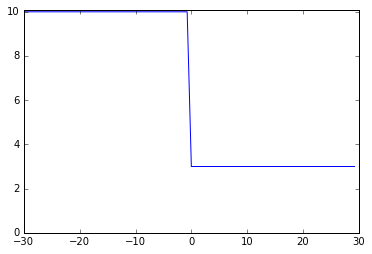

In [19]:
hl = 10.0
hr = 3.0
x,h,hu = dambreak(L=30, hl=hl, hr=hr, dx=dx, nt=nt)
plt.plot(x,h[0,:])
plt.ylim(0.0,10.1)

In [20]:
twet,hwet,huwet = simulate(h,hu,bcs_open,dx,cfl,t0,nt,1e-5,roe)

/home/jose/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in divide


In [21]:
import muscl2
tord2,hord2,huord2 = muscl2.simulate(h,hu,muscl2.bcs_open,dx,cfl,t0,nt)

muscl2.py:169: RuntimeWarning: invalid value encountered in divide
  u_n = np.where(h[n,:]>1e-5, hu[n,:]/h[n,:], 0.)


In [22]:
import dambreak as dbsol


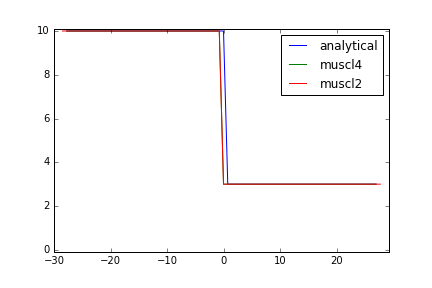
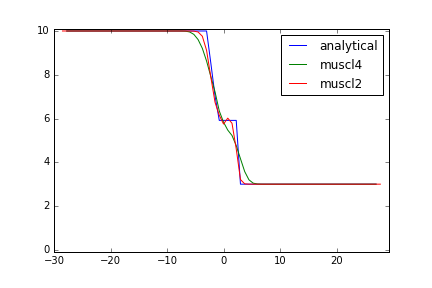
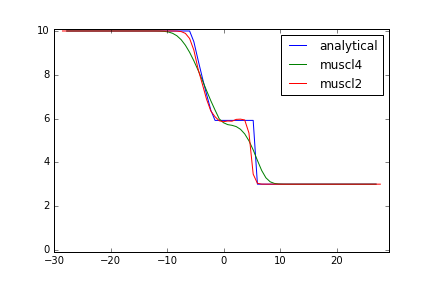
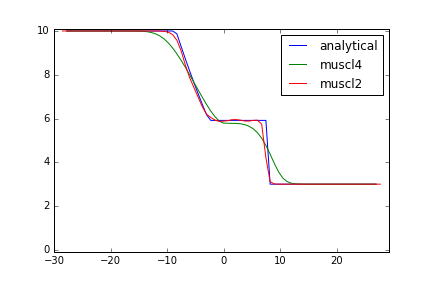
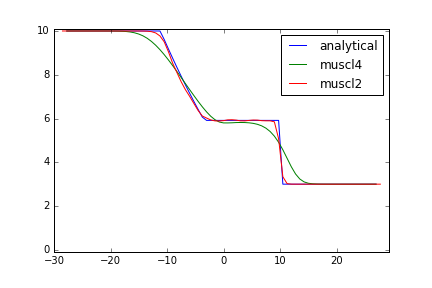
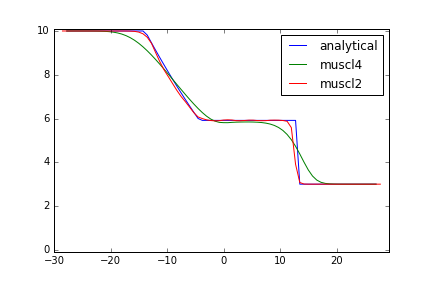
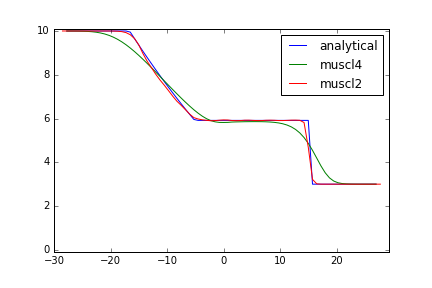
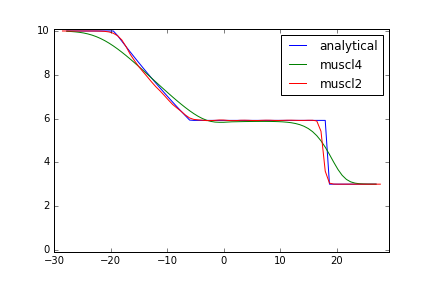
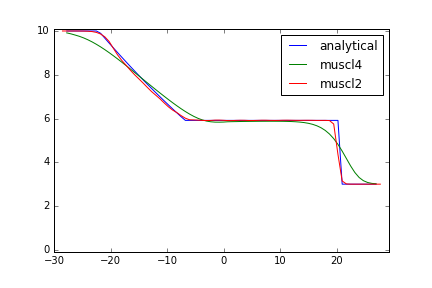
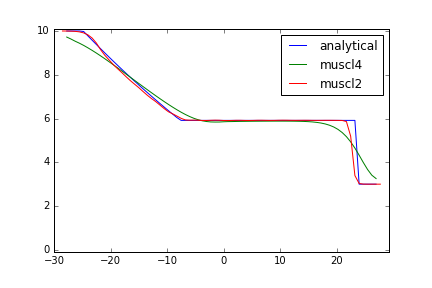
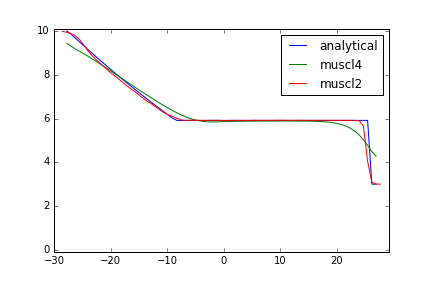
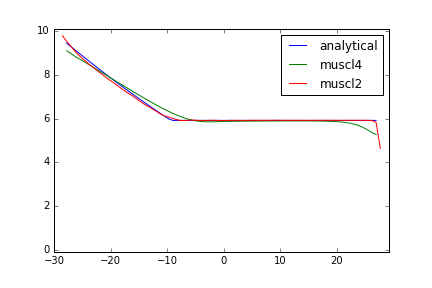
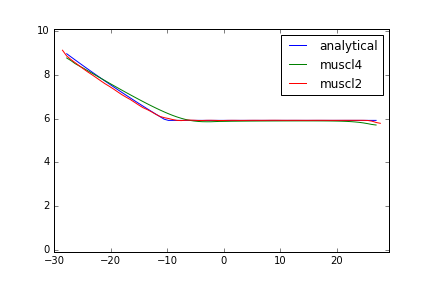
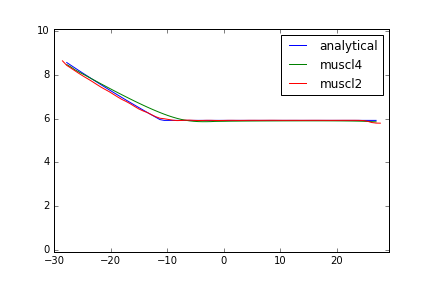
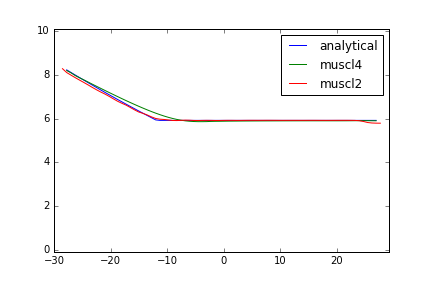
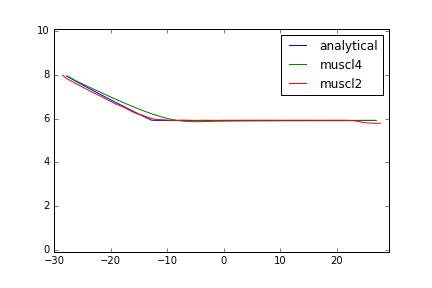
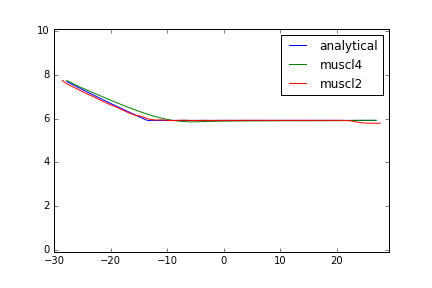
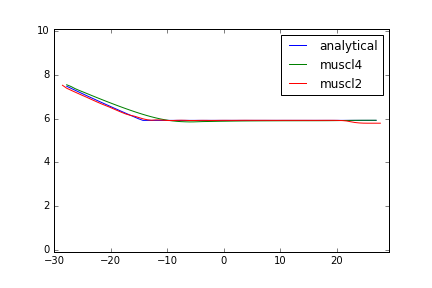
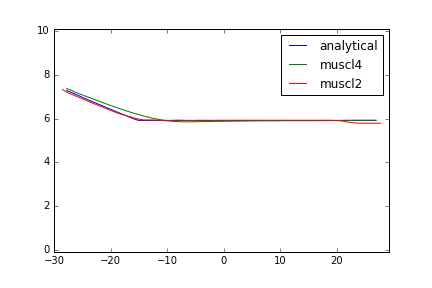
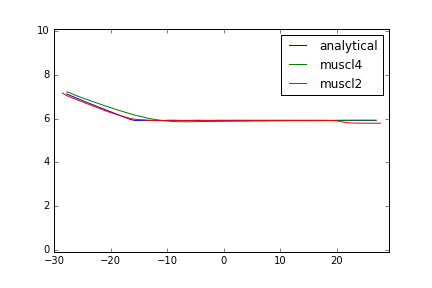
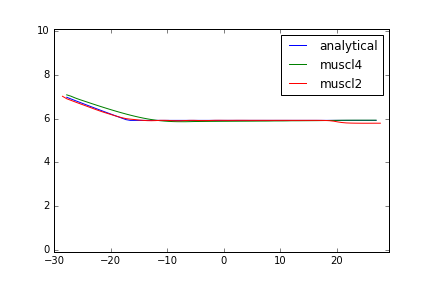
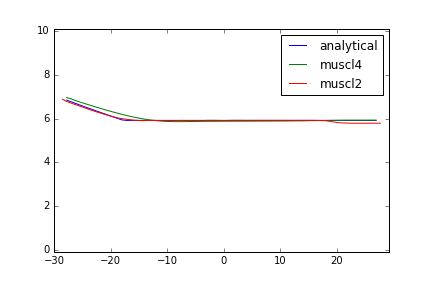
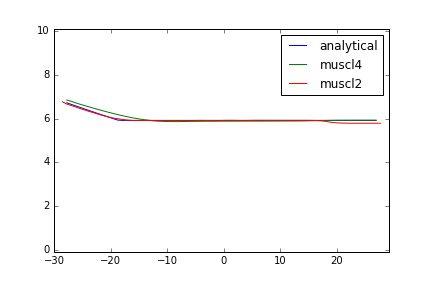
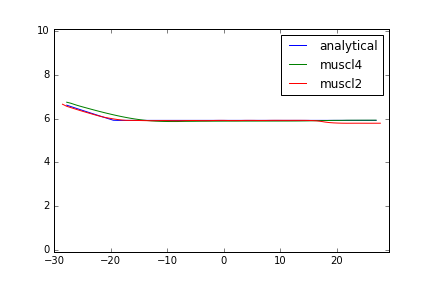
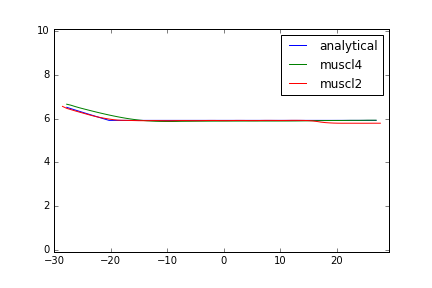
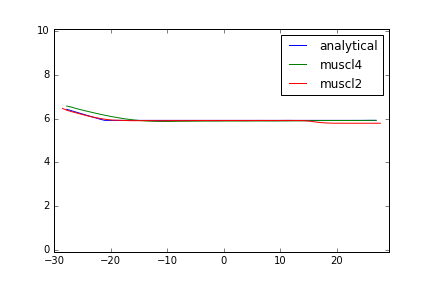
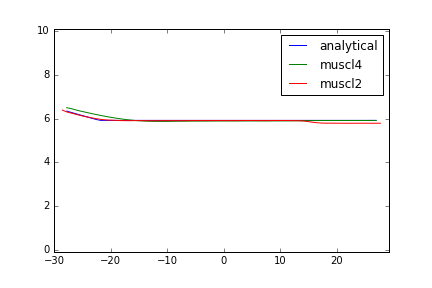
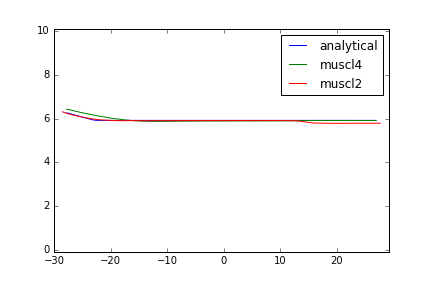
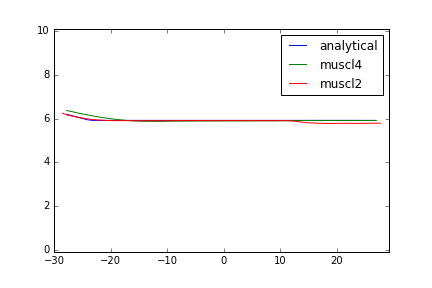

In [28]:
from matplotlib import animation
from JSAnimation import IPython_display

fig = plt.figure()
ax = plt.axes(xlim=(x.min(), x.max()), ylim=(-0.1, 10.1))
line3, = ax.plot([],[],label='analytical')
# line1, = ax.plot([], [],label='surfroe4')
line2, = ax.plot([], [],label='muscl4')
line4, = ax.plot([],[],label='muscl2')
plt.legend()
# plt.plot(x,d)


def animate(i):
    i = min(10*i,nt)
    ha,ua = dbsol.SWAnalyticalSolutionWet(x[3:-3],twet[i],0.0,hl,hr,9.81)
#     line1.set_data(x[3:-3], h1[i,3:-3])
    line2.set_data(x[3:-3], hwet[i,3:-3])
    line3.set_data(x[3:-3],ha)
    line4.set_data(x[2:-2], hord2[i,2:-2])
    return line2,

animation.FuncAnimation(fig, animate,
                        frames=nt/10-1, interval=45)

## Dry case

(0.0, 10.1)

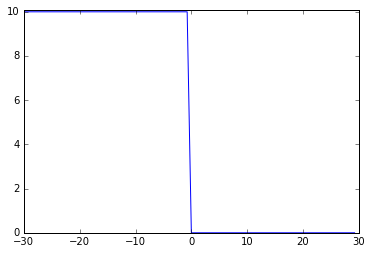

In [29]:
hl = 10.0
hr = 0.0
x,h,hu = dambreak(L=30, hl=hl, hr=hr, dx=dx, nt=nt)
plt.plot(x,h[0,:])
plt.ylim(0.0,10.1)

In [30]:
tdry,hdry,hudry = simulate(h,hu,bcs_open,dx,cfl,t0,nt,1e-5,roe)

negative h :(, hl,hr=12.125,-2.125


/home/jose/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in divide
/home/jose/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in sqrt
/home/jose/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in sqrt
/home/jose/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in sqrt
/home/jose/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in sqrt
/home/jose/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in sqrt
/home/jose/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater
/home/jose/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in abs

dambreak.py:26: RuntimeWarning: divide by zero encountered in divide
  h = np.where(x[:]<=xa, hl, np.where(x<xb,4./(9.*g)*np.power(c-(x[:]-x0)/(2.*t),2),0))
dambreak.py:26: RuntimeWarning: invalid value encountered in divide
  h = np.where(x[:]<=xa, hl, np.where(x<xb,4./(9.*g)*np.power(c-(x[:]-x0)/(2.*t),2),0))
dambreak.py:27: RuntimeWarning: divide by zero encountered in divide
  u = np.where(x[:]<=xa, 0,np.where(x<xb, 2./3.*(c+(x[:]-x0)/t),0))
dambreak.py:27: RuntimeWarning: invalid value encountered in divide
  u = np.where(x[:]<=xa, 0,np.where(x<xb, 2./3.*(c+(x[:]-x0)/t),0))
dambreak.py:26: RuntimeWarning: invalid value encountered in less_equal
  h = np.where(x[:]<=xa, hl, np.where(x<xb,4./(9.*g)*np.power(c-(x[:]-x0)/(2.*t),2),0))
dambreak.py:26: RuntimeWarning: invalid value encountered in less
  h = np.where(x[:]<=xa, hl, np.where(x<xb,4./(9.*g)*np.power(c-(x[:]-x0)/(2.*t),2),0))
dambreak.py:27: RuntimeWarning: invalid value encountered in less_equal
  u = np.where(x[:]<=xa, 0,n


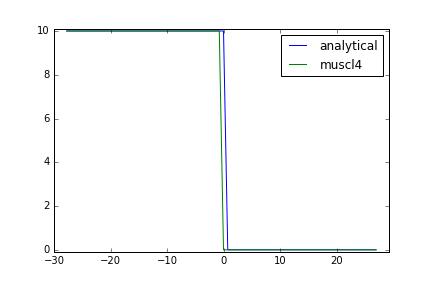
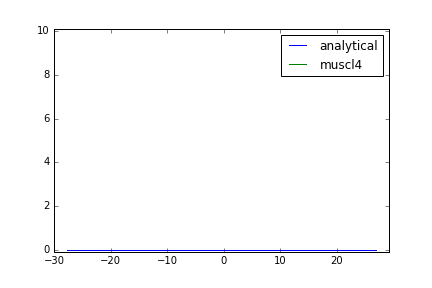
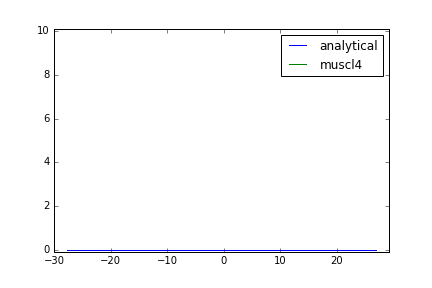
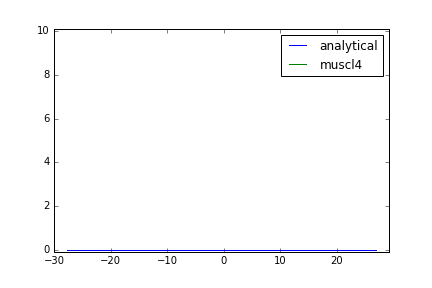
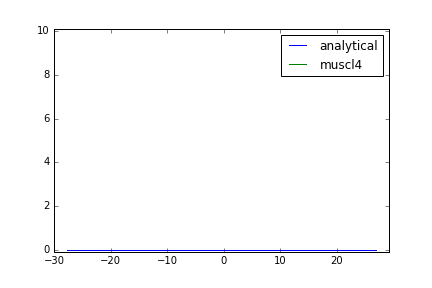
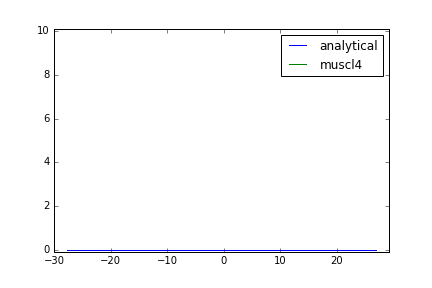
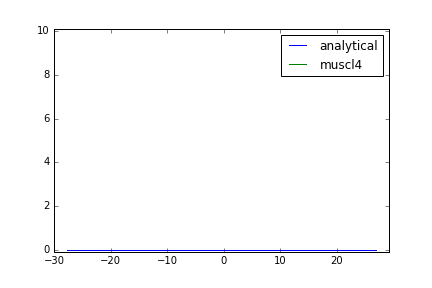
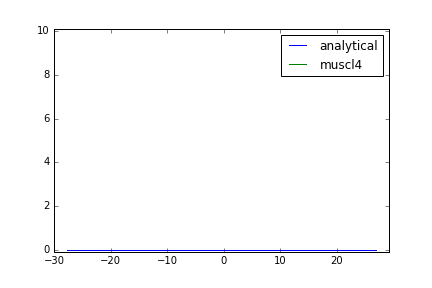
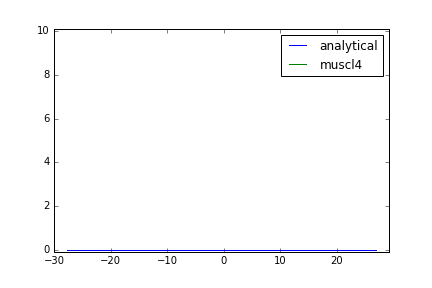
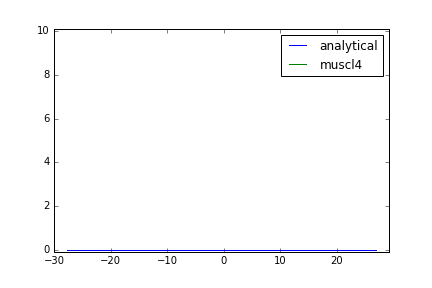
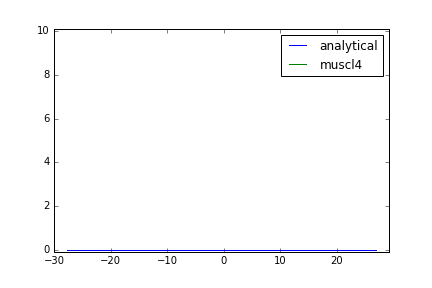
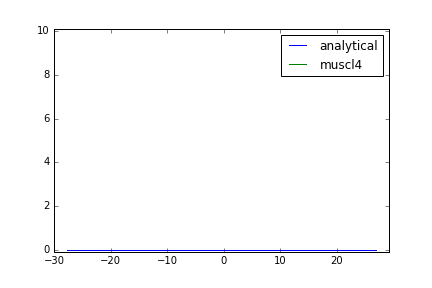
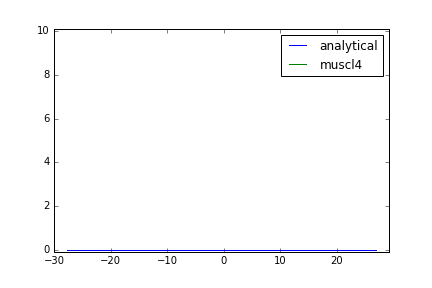
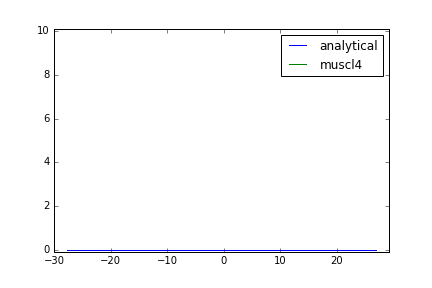
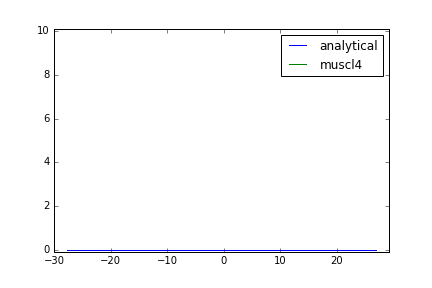
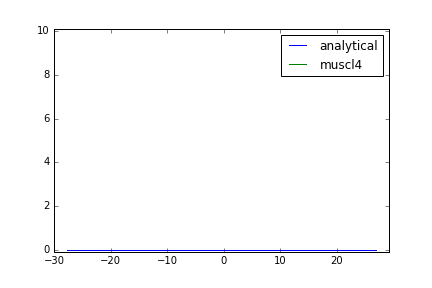
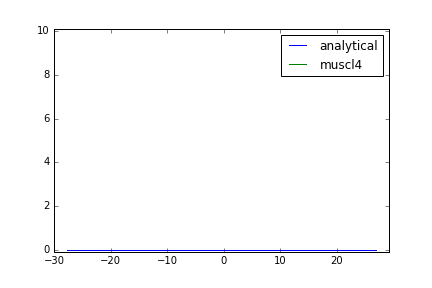
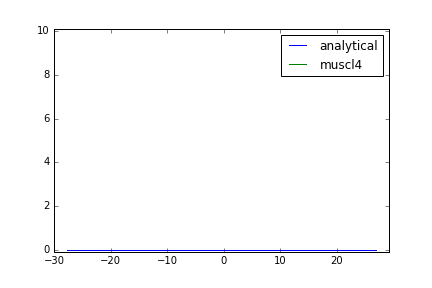
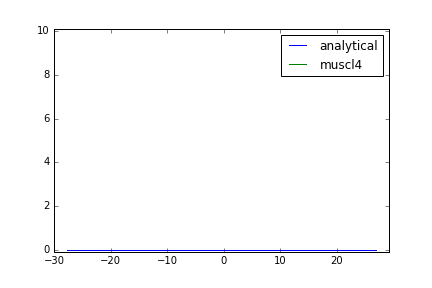
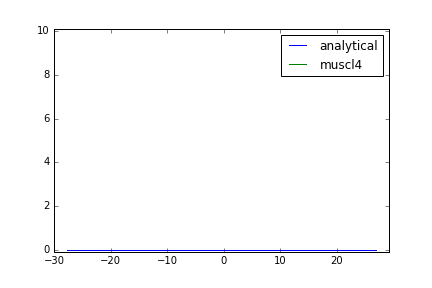
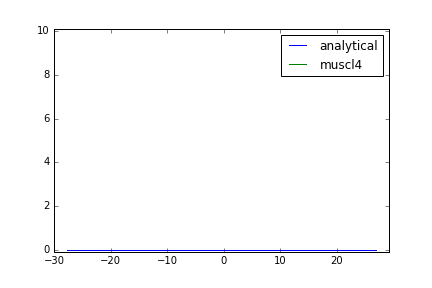
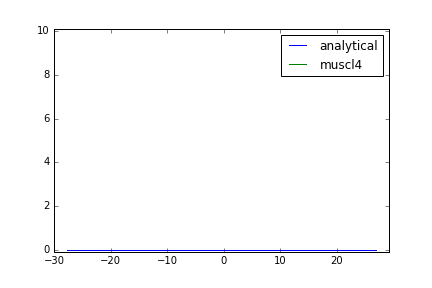
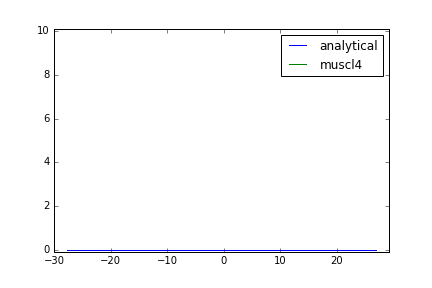
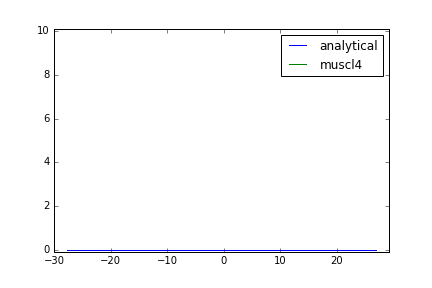
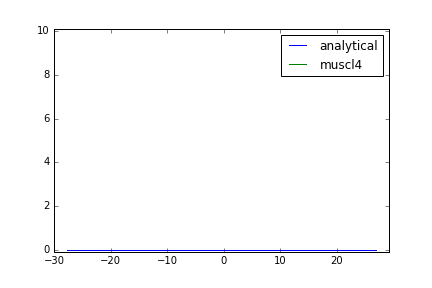
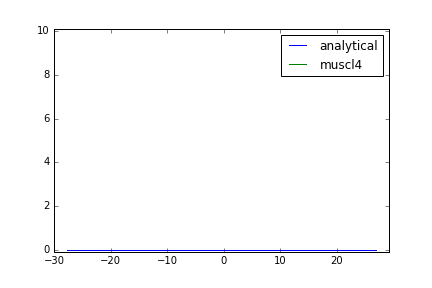
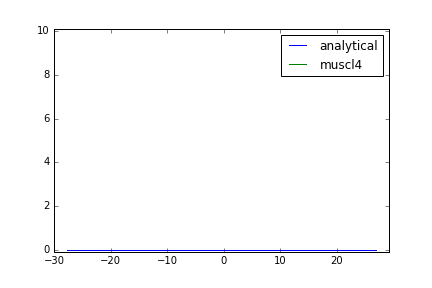
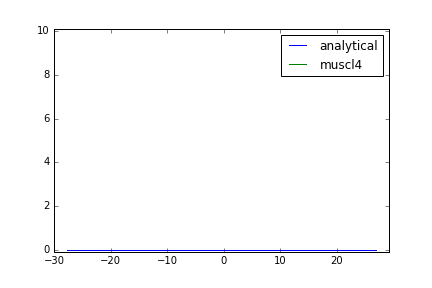
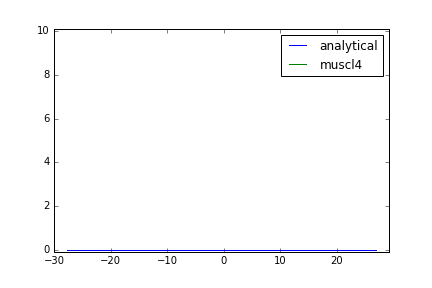

In [31]:
fig = plt.figure()
ax = plt.axes(xlim=(x.min(), x.max()), ylim=(-0.1, 10.1))
line3, = ax.plot([],[],label='analytical')
line2, = ax.plot([], [],label='muscl4')
plt.legend()
def animate(i):
    i = min(10*i,nt)
    ha,ua = dbsol.SWAnalyticalSolutionDry(x[3:-3],tdry[i],0.0,hl,9.81)
    line2.set_data(x[3:-3], hdry[i,3:-3])
    line3.set_data(x[3:-3],ha)
    return line2,
animation.FuncAnimation(fig, animate,
                        frames=nt/10-1, interval=45)

In [32]:
hawet = np.zeros((nt,x.shape[0]))
uawet = np.zeros((nt,x.shape[0]))
huawet = np.zeros((nt,x.shape[0]))

for i in range(nt):
    hawet[i,:],uawet[i,:] = dbsol.SWAnalyticalSolutionWet(x,twet[i],0.0,hl=10.0,hr=1.0, g=9.81)
huawet = hawet*uawet    

In [33]:
hadry = np.zeros((nt,hdry.shape[1]))
uadry = np.zeros((nt,hdry.shape[1]))

for i in range(nt):
    hadry[i,:], uadry[i,:] = dbsol.SWAnalyticalSolutionDry(x, tdry[i], 0.0, 10.0, 9.81)
huadry = hadry*uadry

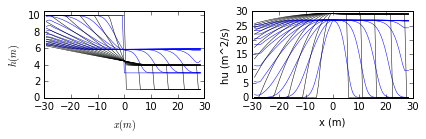

In [34]:
plt.figure(figsize=(6,2))
dit = 20
plt.subplot(121)
plt.plot(x[1:-1],hwet[::dit,1:-1].T,'-b',lw=0.5);
plt.plot(x[1:-1],hawet[::dit,1:-1].T,'-k',lw=0.5)
plt.ylim(0.0,10.5)
plt.xlabel(r'$x (m)$')
plt.ylabel(r'$h (m)$')
plt.subplot(122)
plt.plot(x[1:-1],huwet[::dit,1:-1].T,'-b',lw=0.5);
plt.plot(x[1:-1],huawet[::dit,1:-1].T,'-k',lw=0.5);
# plt.ylim(0.0,10.5)
plt.xlabel('x (m)')
plt.ylabel('hu (m^2/s)')
plt.tight_layout()
plt.savefig('../figures/NsweSolvers/db4_wet.png',dpi=300,bbox_inches='tight')

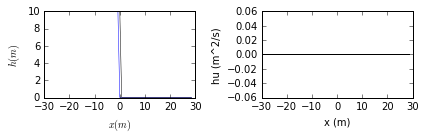

In [35]:
plt.figure(figsize=(6,2))
dit = 20
plt.subplot(121)
plt.plot(x[1:-1],hdry[::dit,1:-1].T,'-b',lw=0.5);
plt.plot(x[1:-1],hadry[::dit,1:-1].T,'-k',lw=0.5)
# plt.ylim(0.0,10.5)
plt.xlabel(r'$x (m)$')
plt.ylabel(r'$h (m)$')
plt.subplot(122)
plt.plot(x[1:-1],hudry[::dit,1:-1].T,'-b',lw=0.5);
plt.plot(x[1:-1],huadry[::dit,1:-1].T,'-k',lw=0.5);
# plt.ylim(0.0,10.5)
plt.xlabel('x (m)')
plt.ylabel('hu (m^2/s)')
plt.tight_layout()
plt.savefig('../figures/NsweSolvers/db4_dry.png',dpi=300,bbox_inches='tight')